In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn
# import resnet_cifar

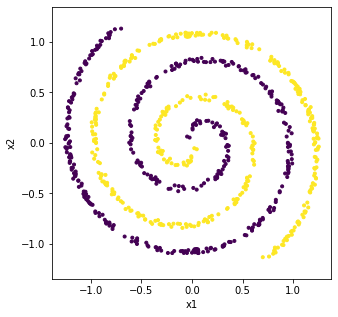

In [3]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

x, y = twospirals(400)
x, y = x/10, y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [4]:
device = torch.device("cuda:0")

In [5]:
criterion = nn.BCELoss()

In [6]:
xx, yy = xx.to(device), yy.to(device)

## Any function as metric

In [7]:
class FunctionDT(nn.Module):
    
    def __init__(self, input_dim, num_centers, func, inv_temp=0.):
        '''
        func [input_dim -> 1]
        '''
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.func = func
        
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
    
    def forward(self, x):
        z = x.unsqueeze(1) - self.centers.unsqueeze(0)
        dists = self.func(z).squeeze(-1)
        dists = dists*torch.exp(self.inv_temp)

#         dists = dists*torch.exp(self.inv_temp)
        dists = dists-dists.mean(dim=-1, keepdim=True)
        dists = dists/torch.sqrt(dists.var(dim=-1, keepdim=True) + 1e-6)
        return -dists

In [8]:
from classes import DistanceRegressor, ConvexNN
from nflib.flows import SequentialFlow, ActNorm
import nflib.res_flow as irf

## Merge all models into single and benchmark

In [9]:
def get_models(h = 5, device='cpu'):
    layer1 = {
        "l_0.5":dtnn.DistanceTransform(2, h, p=0.5, bias=False),
        "l_1":dtnn.DistanceTransform(2, h, p=1, bias=False),
        "l_2":dtnn.DistanceTransform(2, h, bias=False),
        "l_inf":dtnn.DistanceTransform(2, h, p=20, bias=False),
        "stereo":dtnn.StereographicTransform(2, h, bias=False),
        "linear":nn.Linear(2, h, bias=False)
    }
    net_dict = {}
    for key in layer1:
        net = nn.Sequential(
            layer1[key],
            nn.BatchNorm1d(h),
            nn.ELU(),
            nn.Linear(h, 1),
            nn.Sigmoid()
            )
        net_dict[key] = net.to(device)
    return net_dict

In [10]:
def get_models_func(h = 5, func_h=20, device='cpu'):
    layer1 = {
        "convex":ConvexNN([2, func_h, 1]),
        "invex":nn.Sequential(
                    ActNorm(2),
                    irf.ResidualFlow(2, [func_h], activation=irf.LeakyReLU),
                    ActNorm(2),
                    DistanceRegressor(2),
                    ),
#         "ordinary":nn.Sequential(nn.Linear(2, func_h), nn.LeakyReLU(), nn.Linear(func_h, 1)),
        "ordinary":nn.Sequential(
                    ActNorm(2),
                    irf.ResidualFlow(2, [func_h], activation=irf.LeakyReLU),
                    ActNorm(2),
                    DistanceRegressor(2),
                    ),
    }
    irf.remove_spectral_norm_model(layer1["ordinary"])

    net_dict = {}
    for key in layer1:
        net = nn.Sequential(
            FunctionDT(2, h, layer1[key]),
            nn.BatchNorm1d(h),
            nn.ELU(),
            nn.Linear(h, 1),
            nn.Sigmoid(),
            )
        net_dict[key] = net.to(device)
    return net_dict

In [ ]:
exp_mse_vals = {}
# for h in [2, 5, 10, 20]:
for h in [3, 5, 10, 20]:
    net_dict = {
#                 **get_models(h, device=device), 
                **get_models_func(h, device=device),
                }
    mse_dict = {}
    for key in net_dict:
        print("_________________________")
        print(f"Experimenting for {key} ; h:{h}")
        net = net_dict[key]
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
        for epoch in range(20000):
            yout = net(xx)
            loss = criterion(yout, yy)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch+1)%100 == 0:
                accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
                print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

            if (epoch+1)%1000 == 0:
                ax = plt.figure(figsize=(6,6)).add_subplot()
                out = (yout.data.cpu().numpy()>0.5).astype(int)
                ax.scatter(x1, x2, c=out, marker= '.')
                plt.show()
                
        mse_dict[key] = float(accuracy)
    exp_mse_vals[str(h)] = mse_dict

In [16]:
# !nvidia-smi

In [13]:
exp_mse_vals

{'3': {'convex': 0.8637499809265137,
  'invex': 0.9362499713897705,
  'ordinary': 0.9424999952316284},
 '5': {'convex': 0.9662500023841858,
  'invex': 0.9962499737739563,
  'ordinary': 1.0},
 '10': {'convex': 1.0, 'invex': 1.0, 'ordinary': 1.0},
 '20': {'convex': 0.9975000023841858, 'invex': 1.0, 'ordinary': 1.0}}

In [14]:
# a = 3
# fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# for i, key in enumerate(["convex", "invex", "ordinary"]):
#     ax[i].contourf(x1*a, x2*a, net_dict[key][0].func(xx*a).data.cpu().numpy().reshape(x1.shape), levels=20)
# plt.show()

In [15]:
'''
{'3': {'l_0.5': 0.625,
  'l_1': 0.675000011920929,
  'l_2': 0.6612499952316284,
  'l_inf': 0.6312499642372131,
  'stereo': 0.6524999737739563,
  'linear': 0.6349999904632568,
  'convex': 0.89124995470047,
  'invex': 0.9350000023841858,
  'ordinary': 1.0},
 '5': {'l_0.5': 0.70374995470047,
  'l_1': 0.643750011920929,
  'l_2': 0.7724999785423279,
  'l_inf': 0.7824999690055847,
  'stereo': 0.9649999737739563,
  'linear': 0.7649999856948853,
  'convex': 0.7837499976158142,
  'invex': 1.0,
  'ordinary': 1.0},
 '10': {'l_0.5': 0.7549999952316284,
  'l_1': 0.8399999737739563,
  'l_2': 1.0,
  'l_inf': 0.8174999952316284,
  'stereo': 1.0,
  'linear': 0.8399999737739563,
  'convex': 0.9587499499320984,
  'invex': 1.0,
  'ordinary': 1.0},
 '20': {'l_0.5': 0.8037499785423279,
  'l_1': 0.8312499523162842,
  'l_2': 1.0,
  'l_inf': 0.8524999618530273,
  'stereo': 1.0,
  'linear': 1.0,
  'convex': 0.8887499570846558,
  'invex': 1.0,
  'ordinary': 1.0}}
'''

"\n{'3': {'l_0.5': 0.625,\n  'l_1': 0.675000011920929,\n  'l_2': 0.6612499952316284,\n  'l_inf': 0.6312499642372131,\n  'stereo': 0.6524999737739563,\n  'linear': 0.6349999904632568,\n  'convex': 0.89124995470047,\n  'invex': 0.9350000023841858,\n  'ordinary': 1.0},\n '5': {'l_0.5': 0.70374995470047,\n  'l_1': 0.643750011920929,\n  'l_2': 0.7724999785423279,\n  'l_inf': 0.7824999690055847,\n  'stereo': 0.9649999737739563,\n  'linear': 0.7649999856948853,\n  'convex': 0.7837499976158142,\n  'invex': 1.0,\n  'ordinary': 1.0},\n '10': {'l_0.5': 0.7549999952316284,\n  'l_1': 0.8399999737739563,\n  'l_2': 1.0,\n  'l_inf': 0.8174999952316284,\n  'stereo': 1.0,\n  'linear': 0.8399999737739563,\n  'convex': 0.9587499499320984,\n  'invex': 1.0,\n  'ordinary': 1.0},\n '20': {'l_0.5': 0.8037499785423279,\n  'l_1': 0.8312499523162842,\n  'l_2': 1.0,\n  'l_inf': 0.8524999618530273,\n  'stereo': 1.0,\n  'linear': 1.0,\n  'convex': 0.8887499570846558,\n  'invex': 1.0,\n  'ordinary': 1.0}}\n"